# Fraud

## Goal

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

## Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes.


You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.


You only have information about the user first transaction on the site and based on that you have to make your classification (“fraud/no fraud”).


These are the tasks you are asked to do:


* For each user, determine their country based on the IP address


* Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model


* Your boss is a bit worried about using a model she doesn’t understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn’t care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?


* Let’s say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output? 

## Load Data

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)

In [2]:
df_fraud = pd.read_csv('Fraud_Data.csv')
df_fraud.shape
df_fraud.head()

(151112, 11)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
df_ip = pd.read_csv('IpAddress_to_Country.csv')
df_ip.shape
df_ip.head()

(138846, 3)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Question 1

In [4]:
ip_to_country = [None] * df_fraud.shape[0]

In [5]:
for i in range(len(ip_to_country)):
    tmp_countries = df_ip[(df_fraud['ip_address'][i] >= df_ip['lower_bound_ip_address']) &
    (df_fraud['ip_address'][i] <= df_ip['upper_bound_ip_address'])]['country'].values
    
    if len(tmp_countries) == 1:
        ip_to_country[i] = tmp_countries

In [6]:
df_fraud['country'] = ip_to_country

In [7]:
df_fraud['country'] = df_fraud['country'].str.get(0)

In [8]:
df_fraud.country.value_counts()

United States                     58049
China                             12038
Japan                              7306
United Kingdom                     4490
Korea Republic of                  4162
                                  ...  
British Indian Ocean Territory        1
Nauru                                 1
Burundi                               1
Vanuatu                               1
Dominica                              1
Name: country, Length: 181, dtype: int64

## Question 2

feature engineering

In [9]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [10]:
df_fraud['signup_time'] = pd.to_datetime(df_fraud['signup_time'])
df_fraud['purchase_time'] = pd.to_datetime(df_fraud['purchase_time'])

In [11]:
df_fraud['time_diff'] = (df_fraud['purchase_time'] - df_fraud['signup_time']).dt.total_seconds()

In [12]:
df_fraud['device_cnt'] = df_fraud.groupby('device_id')['user_id'].transform('count')

In [13]:
df_fraud['ip_cnt'] = df_fraud.groupby('ip_address')['user_id'].transform('count')

In [14]:
df_fraud['country'].fillna('Not_Found', inplace = True)

In [15]:
# keep top 50 countries
bottom_country = df_fraud.groupby('country').size().sort_values(ascending = False)[50:].index

In [16]:
df_fraud['new_country'] = df_fraud['country'].apply(lambda x: 'Others' if x in bottom_country else x)

In [17]:
df = df_fraud.drop(columns = ['user_id','signup_time','purchase_time','device_id','ip_address','country'])

build model

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [20]:
X = df.drop(columns = 'class')
y = df['class']

In [21]:
col_num = ['purchase_value','age','time_diff','device_cnt','ip_cnt']
col_cat = ['source','browser','sex','new_country']

In [22]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.34, random_state = 42)

In [23]:
categorical_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OneHotEncoder(handle_unknown='ignore'))
numerical_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

In [24]:
preprocessing = ColumnTransformer([('cat', categorical_pipe, col_cat),
                                   ('num', numerical_pipe, col_num)])

In [25]:
rf = make_pipeline(preprocessing, RandomForestClassifier(n_estimators = 100, max_features = 3, oob_score = True, random_state=42))

In [26]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['source', 'browser', 'sex',
                                                   'new_country']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                               

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
rf.score(X_train, y_train)

0.9999298125996411

In [29]:
rf.score(X_test, y_test)

0.955215165729189

no overfitting

## ROC

In [30]:
from sklearn.metrics import roc_curve

In [31]:
pred_prob = rf.predict_proba(X_test)

In [32]:
fpr, tpr, threshold = roc_curve(y_test.values, pred_prob[:,1])

(0.0, 1.0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC')

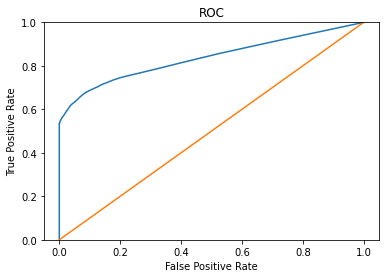

In [33]:
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.ylim([0.,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [34]:
error_cutoff = pd.DataFrame({'cutoff': pd.Series(threshold),
             'fpr': pd.Series(fpr),
             'tpr': pd.Series(tpr)})

In [35]:
# purpose: maximizing (tpr - fpr)
error_cutoff['diff'] = error_cutoff['tpr'] - error_cutoff['fpr']

In [36]:
error_cutoff[error_cutoff['diff'] == error_cutoff['diff'].max()]

,cutoff,fpr,tpr,diff
68,0.15,0.082374,0.673457,0.591082


## Feature Importance

[permutation importance & categorical numerical combination](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

In [37]:
from sklearn.inspection import permutation_importance

impurity_based feature importance

<BarContainer object of 10 artists>

/Users/vincyxia/Projects/py-envs/py-env-main/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


[Text(0, -2.0, 'new_country_Hungary'),
 Text(0, 0.0, 'new_country_European Union'),
 Text(0, 2.0, 'new_country_Czech Republic'),
 Text(0, 4.0, 'new_country_Romania'),
 Text(0, 6.0, 'new_country_Malaysia'),
 Text(0, 8.0, 'new_country_Ireland'),
 Text(0, 10.0, 'new_country_Austria')]

Text(0.5, 1.0, 'Random Forest Feature Importances (MDI)')

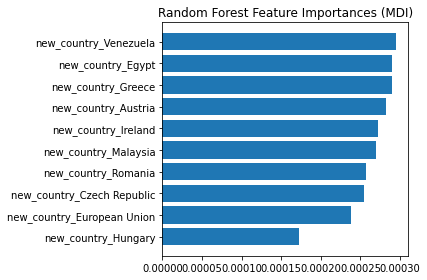

In [38]:
ohe = (rf.named_steps['columntransformer']
         .named_transformers_['cat']
         .named_steps['onehotencoder'])
feature_names = ohe.get_feature_names(input_features=col_cat)
feature_names = np.r_[feature_names, col_num]

tree_feature_importances = (
    rf.named_steps['randomforestclassifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()[:10]

y_ticks = np.arange(0, 10)
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

permutation importance

{'whiskers': [<matplotlib.lines.Line2D at 0x14318b3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x14318bc50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1431a3f90>,
 'medians': [<matplotlib.lines.Line2D at 0x1556a3550>,
 'fliers': [<matplotlib.lines.Line2D at 0x1556a3950>,
 'means': []}

Text(0.5, 1.0, 'Permutation Importances (test set)')

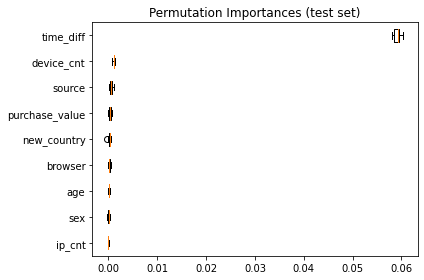

In [39]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[:10]

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x13ef24850>,
 'caps': [<matplotlib.lines.Line2D at 0x152bd2110>,
 'boxes': [<matplotlib.lines.Line2D at 0x13ef24450>,
 'medians': [<matplotlib.lines.Line2D at 0x152bd29d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x152bd2dd0>,
 'means': []}

Text(0.5, 1.0, 'Permutation Importances (train set)')

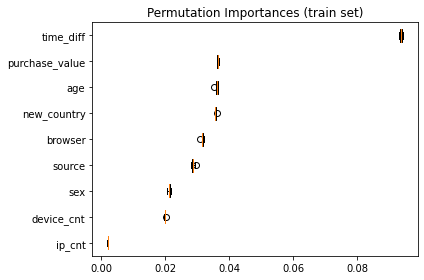

In [40]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

## Partial Dependency

In [41]:
from pdpbox import pdp, info_plots

<AxesSubplot:title={'center':'TimeDiff'}>

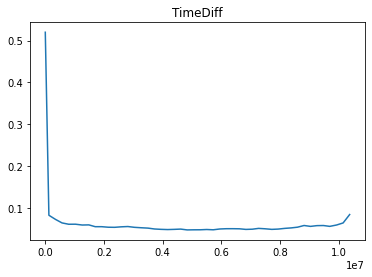

In [42]:
#timediff
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=X_train,      
                          model_features=X_train.columns, 
                          feature='time_diff', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='TimeDiff')
plt.show()

<AxesSubplot:title={'center':'Device_Count'}>

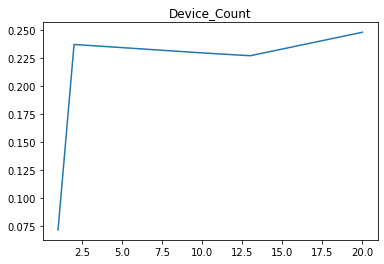

In [43]:
#device count
pdp_iso = pdp.pdp_isolate(model=rf, 
                          dataset=X_train,      
                          model_features=X_train.columns, 
                          feature='device_cnt', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Device_Count')
plt.show()

In [44]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

Text(0.5, 0.98, 'Partial dependence')

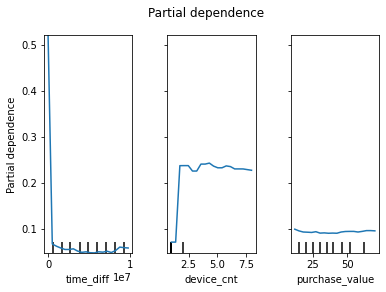

In [45]:
features = ['time_diff', 'device_cnt', 'purchase_value']
plot_partial_dependence(rf, X_train, features,
                        n_jobs=3, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence')
fig.subplots_adjust(wspace=0.4, hspace=0.3)